2022 Nor-s

## [사전학습 모델 사용](https://yeong-jin-data-blog.tistory.com/entry/%EC%82%AC%EC%A0%84%ED%95%99%EC%8A%B5-%EB%AA%A8%EB%8D%B8-%EC%82%AC%EC%9A%A9)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
NAME = 'for_generator_korean'
TRAIN_DATA_DIR = f'../data/{NAME}/train'
VALIDATION_DATA_DIR = f'../data/{NAME}/val'
TEST_DATA_DIR = f'../data/{NAME}/test'
 
TRAIN_SAMPLES = 16000 #24000
VALIDATION_SAMPLES = 2000 #3000
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
EPOCH = 30

## 데이터 로드

https://keras.io/api/preprocessing/image/

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
 
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 16000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## VGG model 사전학습 모델

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
def model_maker(num_class, input_shape=(224, 224, 3)):
    # model = VGG16(weights='imagenet', include_top=True)
    base_model = VGG16(include_top=False, input_shape=input_shape)
    print(len(base_model.layers))
 
    # for layer in base_model.layers[:]:
        # layer.trainable = False
    for layer in base_model.layers[:-2]:
        print('freeze: ', layer.name , str(layer.trainable))
        layer.trainable = False # Top 층을 제외한 나머지 층에서 2개의 층을 새롭게 학습 
 
    input = tf.keras.Input(shape=input_shape)
    custom_model = base_model(input)
    custom_model = tf.keras.layers.GlobalAveragePooling2D()(custom_model)
    custom_model = tf.keras.layers.Dense(32, activation='relu')(custom_model)
    predictions = tf.keras.layers.Dense(num_class, activation='softmax')(custom_model)
    
    return tf.keras.Model(inputs=input, outputs=predictions)

model_final = model_maker(2, input_shape=(224, 224, 3))
model_final.summary()
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

19
freeze:  input_1 True
freeze:  block1_conv1 True
freeze:  block1_conv2 True
freeze:  block1_pool True
freeze:  block2_conv1 True
freeze:  block2_conv2 True
freeze:  block2_pool True
freeze:  block3_conv1 True
freeze:  block3_conv2 True
freeze:  block3_conv3 True
freeze:  block3_pool True
freeze:  block4_conv1 True
freeze:  block4_conv2 True
freeze:  block4_conv3 True
freeze:  block4_pool True
freeze:  block5_conv1 True
freeze:  block5_conv2 True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
    

In [10]:
checkpoint_path = f"./{NAME}_VGG/cp-{EPOCH:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                #  period=5,
                                                 monitor='val_acc',
                                                 mode='max',
                                                 save_best_only=True)

history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
    epochs=EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE,
    callbacks=[cp_callback ])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.6517 - acc: 0.7309
Epoch 1: val_acc improved from -inf to 0.77621, saving model to ./for_generator_korean_VGG\cp-0030.ckpt
250/250 [==============================] - 213s 818ms/step - loss: 0.6517 - acc: 0.7309 - val_loss: 0.4826 - val_acc: 0.7762
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.4675 - acc: 0.7813
Epoch 2: val_acc improved from 0.77621 to 0.78881, saving model to ./for_generator_korean_VGG\cp-0030.ckpt
250/250 [==============================] - 161s 643ms/step - loss: 0.4675 - acc: 0.7813 - val_loss: 0.4598 - val_acc: 0.7888
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.4581 - acc: 0.7830
Epoch 3: val_acc did not improve from 0.78881
250/250 [==============================] - 160s 638ms/step - loss: 0.4581 - acc: 0.7830 - val_loss: 0.5040 - val_acc: 0.7762
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 0.4486 - acc: 0.7884
Epoc

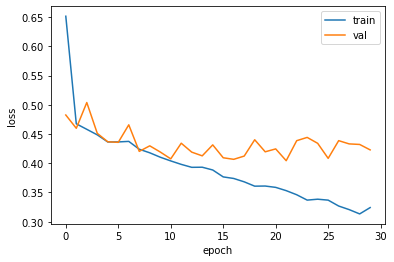

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

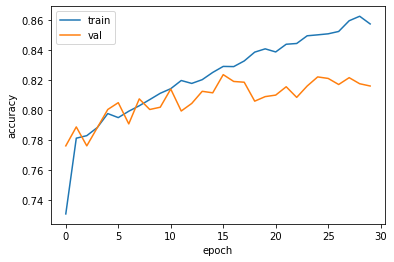

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

## 모델 성능평가

In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [15]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_final.load_weights(latest)

model_final.evaluate(test_generator, steps=VALIDATION_SAMPLES // BATCH_SIZE)


31/31 [==============================] - 10s 304ms/step - loss: 0.3829 - acc: 0.8367


[0.38285115361213684, 0.836693525314331]

In [11]:
model_final.save(f'./{NAME}_VGG_us_accident.h5')
model_final.save(f'./{NAME}_VGG_us_accident/VGG_us_accident')

INFO:tensorflow:Assets written to: ./VGG_us_accident/VGG_us_accident\assets


INFO:tensorflow:Assets written to: ./VGG_us_accident/VGG_us_accident\assets
